In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 10]
matplotlib.rcParams['font.size'] = "32"

# this code simulations the 3srw with trapping

In [4]:
def walkit(k1=1.0,k2=1.0,kap=1.0,v=1.0,dt=1e-2,tmax=10,theta1=0.5,theta2=0.5):
    """
    kap is the trapping rate from rest
    k1 is the inverse mean resting time
    k2 is the inverse mean moving time
    v is the velocity
    tmax is the maximum time to walk
    theta1 is the probability of starting at rest
    theta2 is the probability of starting in motion
    """
    s = int(np.random.random() > theta1) + 1 # initial state
    N = int(tmax/dt) # number of iterations
    X = np.empty(N+1) # displacement array
    R = np.random.random(size=(N,2)) # uniform randoms
    t = 0.0 # initial time
    x = 0.0
    X[0]=x
    for n,(r1,r2) in enumerate(R):
        t += dt
        if s==1: # if in a rest state
            val1 = 1 - np.exp(-k1*dt) > r1 # probability that transition to motion occurs
            val2 = 1 - np.exp(-kap*dt) > r2  # probability that trapping occurs 
            if val1 and not val2: # provided it does not trap and does transition to motion
                s = 2  # move it to the motion state
            elif val2: # otherwise if it did trap 
                s=0 # move it to the trapped state
                #print('trapped at {}'.format(t))
                X[n:]=x
                break
        elif s==2: # if in a motion state
            x = x + v*dt # displacement
            if np.exp(-k2*dt)<r1:
                s = 1   # transitions to rest
        X[n+1] = x
    return X[:-1]

def ens(Nens = 100, k1=1.0,k2=1.0,kap=1.0,v=1.0,dt=1e-2,tmax=10,theta1=0.5,theta2=0.5):
    """ do an ensemble of Nens (number) simulations 
    rows of X are individual simulations"""
    N = int(tmax/dt) # number of iterations
    X = np.empty((Nens,N))
    for n in range(Nens):
        x = walkit(k1=k1,k2=k2,kap=kap,v=v,dt=dt,tmax=tmax,theta1=theta1,theta2=theta2)
        X[n,:]=x
    T = np.arange(0,tmax,dt)
    return T,X

def cumulants(t,flag,k1,k2,kap,v):
    """ this provides the cumulants starting from theta_1= 0 (motion) """
    kp = k1 + k2
    exp=np.exp
    sqrt = np.sqrt
    a = (kap+kp)/2.0
    b = sqrt(a**2-kap*k2)
    A1 = v/(2*b)*(1+(kap+k1)/(b-a))
    B1 = v/(2*b)*(-1+(kap+k1)/(a+b))
    C1 = -v/(2*b)*(1/(b-a)+1/(a+b))*(kap+k1)
    def A2(t):
        out = b+(b-a)*(b*t-1)+2*(kap+k1)*(b*t-1)
        out += (kap+k1)**2/(a-b)**2*(-a*b*t+a+b*(b*t-2))
        return v**2/(2*b**3)*out
    def B2(t):
        out = b-(a+b)*(b*t+1)+2*(kap+k1)*(b*t+1) # sign is correct here.
        out += -(kap+k1)**2/(a+b)**2*(b*t*(a+b)+a+2*b)
        return v**2/(2*b**3)*out
    C2 = v**2/(2*b**3)*(kap+k1)**2*((a+2*b)/(a+b)**2 + (-a+2*b)/(a-b)**2)
    if flag==1: # compute the mean
        return A1*exp((b-a)*t)+B1*exp(-(a+b)*t)+C1
    elif flag==2: # compute the var
        out = (A2(t)-2*A1*C1-A1**2*exp((b-a)*t))*exp((b-a)*t)
        out += (B2(t)-2*B1*C1-B1**2*exp(-(a+b)*t))*exp(-(a+b)*t)
        out += C2 - C1**2 - 2*A1*B1*exp(-2*a*t)
        return out

In [5]:
tmotion = 10.0
trest = 100.0
ttrap = 1000.0

k2 = 1/tmotion
k1 = 1/trest
kap = 1/ttrap
v = 0.5
theta1 = 0.0
theta2 = 1.0
T,X = ens(100,dt=1e-3,tmax=10000,k1=k1,k2=k2,kap=kap,theta1=theta1,theta2=theta2,v=v)

In [6]:
# compute variance
var = X.var(0)
# resample and plot points with geometric spacing
tmin = 1e-3 # smallest time to account for
tmax = T.max() # largest 
nperorder = 10 # number of points to keep per order of magnitude 
ts = np.geomspace(tmin,tmax,nperorder*int(np.ceil(np.log10(tmax/tmin)))) # set of sampling times
digits = np.digitize(T, ts) # indices of T into the bins of ts
var_ds = [var[digits==j].mean() for j in range(0,len(ts))] # downsampled variance

/home/kpierce/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:9: RuntimeWarning: Mean of empty slice.
/home/kpierce/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(0.1, 100000.0)

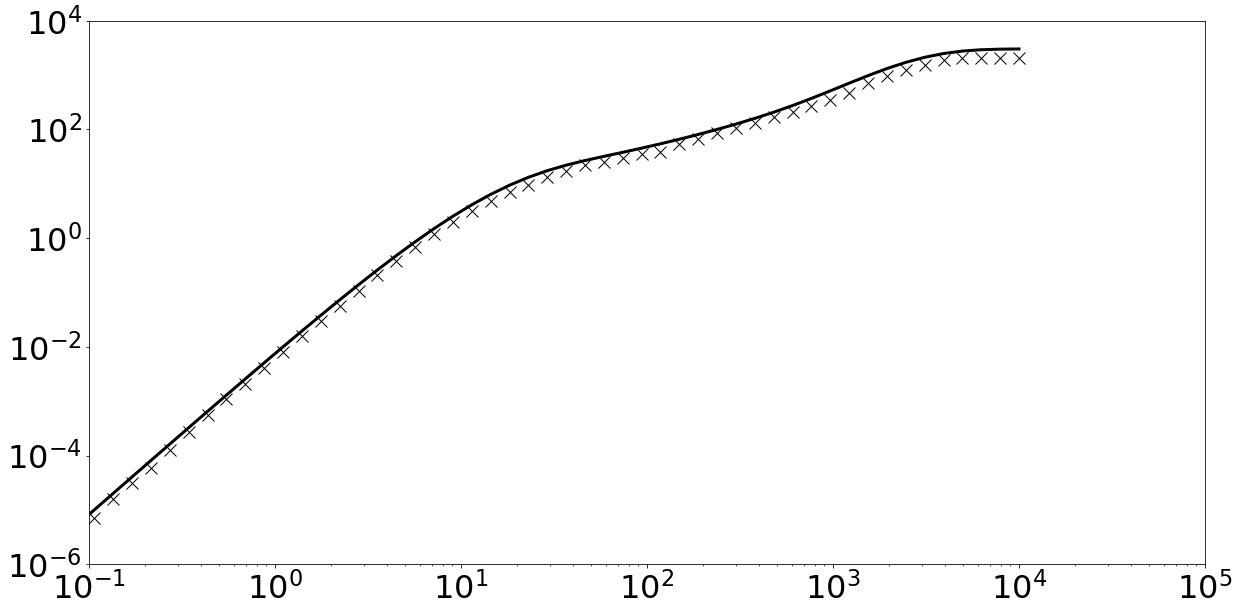

In [7]:
#plt.loglog(T,var,color='black')
plt.loglog(ts,var_ds,'x',color='black',markersize=12)
plt.loglog(ts,cumulants(ts,2,k1,k2,kap,v),color='black',lw=3)

plt.ylim(1e-6,1e4)
plt.xlim(1e-1,1e5)

In [ ]:
tm = 1
tr = 10
tt = 100000
k1 = 1/tr
k2 = 1/tm
kap = 1/tt
v=0.1
t = np.geomspace(1e-3,1e7,100)
plt.loglog(t,cumulants(t,2,k1,k2,kap,v),color='blue',lw=2)#,marker='x',linestyle='None')
plt.ylim(1e-8,1e8)
plt.xlim(1e-3,1e7)

# k1/(k1+k2) is fraction of time spent in motion
# k2/(k1+k2) is fraction of time spent at rest

# crossover from 1st ballistic regime
time1 = 1/np.sqrt(k1*k2)
plt.axvline(time1,color='black')

# crossover zone from 2nd ballistic regime
tau1 = 1/kap
tau2 = 1/(k1*kap/(k1+k2))
time3 = np.sqrt(tau1*tau2)
plt.axvline(time3,color='black')
plt.xlabel(r'$t$',fontsize=12)
plt.ylabel(r'$\sigma_x^2(t)$',rotation=0,fontsize=12)

# crossover zone into 2nd ballistic regime
#plt.axvline(np.sqrt(1/kap/k2))
#plt.axvline(np.sqrt(1/kap*1/(k1*kap/(k1+k2))))

# mix the lower two times... 
time2 = (1/k1*tau2)**(1/2)
plt.axvline(time2,color='black')

fig = plt.gcf()
fig.set_figheight(7/1.6)
fig.set_figwidth(7)
fig.savefig('../grl/figures/diffusion.png', bbox_inches='tight',dpi=600)

In [ ]:

val = 1e-2
# local range
t0 = np.geomspace(1e-2,time1,100)
plt.loglog(t0,t0**3*val,linestyle='-.',color='black')
val = (t0**3*val).max()
# intermediate range
t1 = np.geomspace(time1,time2,100)
plt.loglog(t1,t1/t1.min()*val,linestyle='-.',color='black')
val = (t1/t1.min()*val).max()
# global range
t2 = np.geomspace(time2,time3,100)
plt.loglog(t2,t2**3/(t2**3).min()*val,linestyle='-.',color='black')
# geomorphic range